In [1]:
# setup
import pandas as pd
import collections as co
import numpy as np
import seaborn as sns
import itertools as it
import matplotlib # A must 
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pydotplus 
from matplotlib import cm
from sklearn import datasets
from sklearn import model_selection as skms
from sklearn import metrics
from sklearn import neighbors
from sklearn import tree
from sklearn import svm
from sklearn import naive_bayes
from sklearn import linear_model
from sklearn import dummy
from sklearn import model_selection as skms
from sklearn import discriminant_analysis
from time import sleep
from PIL import Image
%matplotlib inline

In [2]:
iris = datasets.load_iris()

# standard iris dataset
tts = skms.train_test_split(iris.data, iris.target, 
                            test_size=.33, random_state=21)
(iris_train_ftrs, iris_test_ftrs, 
 iris_train_tgt,  iris_test_tgt) = tts

# one-class variation
useclass = 1
tts_1c = skms.train_test_split(iris.data, iris.target==useclass, 
                               test_size=.33, random_state = 21)
(iris_1c_train_ftrs, iris_1c_test_ftrs, 
 iris_1c_train_tgt,  iris_1c_test_tgt) = tts_1c

#How to understand "iris.target==useclass"???
#print(iris_1c_train_tgt)
#print(iris_1c_test_tgt)

## Selected classifiers

**Revisiting classification**

So far, we have discussed two classifiers: NB and $k$-NN. Classification is simple, for instance, if you ask a 6-year-old boy to classify the shapes, crosses and circles, he should find the answer in 5 seconds. (Picture on the whiteboard)

However, we may think a little more on the answers from the child:

   * What is the rule that the child has followed in this simple classification? Drawing a straight line? Using more than one lines? The line has to be parallel to the edge of the paper?
   
   * When we say "Good job" to this child, how do we mean by "good"?
   
The discussion above leads to two important aspects of the classification: The constraints on the boundaries and the evaluation of the methods. 

Before creating a method, mathematicians often put some assumptions on what is happening with the data, which is equivalent to set constraints on how we separate the data. 

A classifier gives the prediction of the concerning output feature in the following ways: for instance, with $k$-NN, the “best" predicted feature are given by voting, which can be regarded as the class with the biggest probability given the input features; with NB, the probability of each class given the input features are calculated by estimating the empirical joint distribution of the input features and the output feature.

This is to say, it is equivalent for the classifiers to send out a predicted output feature as a class among $\{True, False\}$, $\{-1, 0, 1\}$, $\{0, 1\}$ or a conditional probability of each class given the input features.

To evaluate the classifier, the simplest way is to consider the accuracy, however, for instance （Graph on the white board), the crosses and the circles can be perfectly separated, is there any idea to compare a curved boundary and a linear boundary?

In this lecture, we shall introduce the following methods

  * Decision tree
  * Support vector classifier
  * logistic regression
  * Discriminant analysis
  
Basically, in that order, these methods introduce increasing numbers of assumptions.

In general, we may never know if these assumptions are well satisfied. We always try multiple methods, cross-validate, and use the method with the best cross-validated results as our final tool.

In [3]:
def plot_boundary(ax, data, tgt, model, dims, grid_step = .01):
    # grab a 2D view of the data and get limits
    twoD = data[:, list(dims)]
    min_x1, min_x2 = np.min(twoD, axis=0) + 2 * grid_step
    max_x1, max_x2 = np.max(twoD, axis=0) - grid_step


    # make a grid of points and predict at them
    xs, ys = np.mgrid[min_x1:max_x1:grid_step,
                      min_x2:max_x2:grid_step]
    grid_points = np.c_[xs.ravel(), ys.ravel()]
    # warning:  non-cv fit
    preds = model.fit(twoD, tgt).predict(grid_points).reshape(xs.shape)

    # plot the predictions at the grid points
    ax.pcolormesh(xs,ys,preds,cmap=plt.cm.coolwarm)
    ax.set_xlim(min_x1, max_x1)#-grid_step)
    ax.set_ylim(min_x2, max_x2)#-grid_step)

**Decision tree (DT)**

The strategy of a decision tree is to ask questions. Similar to the game: guessing the number between 1 to 100 that your friend thinks about. We can always write a decision tree when playing this game (graph on the white board).

Or, we look at the following example

![dt](Decision-Tree-formulated-using-C45-for-Risk-of-Hypertension.png)

The single question on the top is called *root* of the tree and the scattered nodes at the bottom are called the *leaves*.

With "sklearn", a DT model can be built by simply type "tree.DecisionTreeClassifier" with the "max_depth" option. 

Let us look into the result with "iris" data.

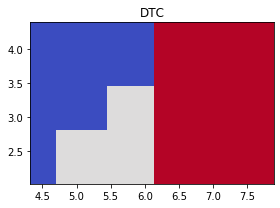

In [4]:
tree_classifiers = {'DTC' : tree.DecisionTreeClassifier(max_depth=3)}
#tree_classifiers = {'DTC' : tree.DecisionTreeClassifier(max_depth=8)}
fig, ax = plt.subplots(1,1,figsize=(4,3))
for name, mod in tree_classifiers.items():
    # plot_boundary only uses specified columns
    # [0,1] [sepal len/width] to predict and graph.  
    plot_boundary(ax, iris.data, iris.target, mod, [0, 1])
    ax.set_title(name)
plt.tight_layout()

# [0, 1] means we pick only the first and second dim of the input features
# That is the sepal length and the sepal width

We display a 2D graph concerning the dimension "sepal length" and "sepal width" of the input features. 

The red region is setosa and the blue and gray are other two classes.

The DT resolves the classification problem by breaking down the entire space of data into smaller and smaller regions. We say that the whole space is broken up and the model creates a partition. 

$$
target = \sum_{Region \in Partition} c_R {\bf 1}_{example \in 
Region}
$$

where $c_R$ is the class label of the region.

The option "max_depth" controls when it stops the breakdown. (Can you easily find from the graph above that this is a result from DT with max_depth = 3? and why the boundary are straight segments?)

Indedd, the option "max_depth" controls the number of level of questions that a model can ask. A modest depth of the DT prevents overfitting. Theoretically, as long as we build sufficiently deep DT, the accuracy on the training set could reach 100%. In particular, the singleton with only one example becomes a region in the partition. However, the predictive capacity will be poor. 

Another important question is what is the best way to raise questions. There are a number of major tree-building algorithms. Among them 

  * ID3 by Quinlan
  * C4.5 and C5.0 by Quinlan
  * CART (Classification and regression tree)
  
are the most popular.  

In [5]:
#tree.DecisionTreeClassifier?

The tree-building algorithm use the following steps:

  * Evaluate the set of features and splits and pick a "best" feature and split;
  * Add a node to the tree that represents the feature-split;
  * For each descendant, work with the matching data and either
    * if the targets are similar enough, return a predicted target; 
    * if not, return to the first step and repeat.
    
Each of these steps can be implemented and limited in different ways. The DT algorithms control

  * what splits and partitions are allowed (for instance, CART is a binomial tree)
  * how features splits are evaluated (for instance, ID.3, C4.5: information gain ration; CART: Gini)
  * other limits (for instance, minimum number of examples at a leaf)    

We remark here 

  * comparing two examples: even all observable features are the same, the decision might be left to chance, that is to say their output features could be different; (unobservable features, error in measurements...) 
  * DT could not explain well when decisions (output features) form a time series.

**Evaluation of DT**

In [6]:
# quite well
dtc = tree.DecisionTreeClassifier()
skms.cross_val_score(dtc, 
                   iris.data, iris.target, 
                   cv=3, scoring='accuracy') # sorry

array([0.98, 0.92, 0.98])

**Visualization of DT**

In [7]:
iris_1c_tree = (tree.DecisionTreeClassifier()
                    .fit(iris_1c_train_ftrs, iris_1c_train_tgt))

In [8]:
#pip install pydotplus

In [9]:
#pip install GraphViz

In [10]:
# using an additional library
# conda install pydotplus
# pip install pydotplus
import pydotplus 
from PIL import Image
dot_data = tree.export_graphviz(iris_1c_tree, out_file=None) 
graph = pydotplus.graph_from_dot_data(dot_data)
graph.write_png("outputs/iris_1c.png")
im=Image.open('outputs/iris_1c.png')
im.show()

In [11]:
iris_tree = (tree.DecisionTreeClassifier(max_depth=2)
                 .fit(iris_train_ftrs, iris_train_tgt))

In [12]:
# no added lib. to produce .dot file
with open("outputs/iris.dot", 'w') as f:
    dot_data = tree.export_graphviz(iris_tree, out_file=f, 
                                    feature_names=iris.feature_names,  
                                    class_names=iris.target_names,  
                                    filled=True, rounded=True)

# the following '!' lines are "shell" commands
# uses the 'dot' program to convert to dot -> png
!dot -Tpng outputs/iris.dot -o outputs/iris.png
!rm outputs/iris.dot

im=Image.open('outputs/iris.png')
im.show()

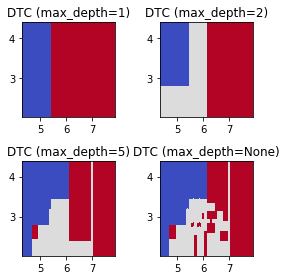

In [13]:
fig, axes = plt.subplots(2,2,figsize=(4,4))

depths = [1, 2, 5, None]
for depth, ax in zip(depths, axes.flat):
    dtc_model = tree.DecisionTreeClassifier(max_depth=depth)
    # plot_boundary only uses specified columns [0,1]
    # so we are only predicting with sepal length and width
    plot_boundary(ax, iris.data, iris.target, dtc_model, [0,1])
    ax.set_title("DTC (max_depth={})".format(dtc_model.max_depth))

plt.tight_layout()

**Support vector classifier**
If drawing a line between the crosses and the dots on paper as simple as possible, the mathematics simply fall apart. Let's look at the perfectly separable case. Here are three possible lines. In fact, we have infinitely many candidates as boundary.

What line has a strong case for being the best around? The black one! Why?

  * It stays far away from the data
  * It is the most cautious line: maximum margin separator, which keeps both classes as far from itself as possible

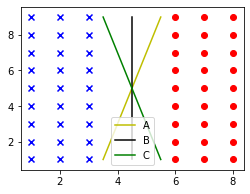

In [14]:
fig, ax = plt.subplots(1,1,figsize=(4,3))

# fancy way to get cross-product of points
left  = np.mgrid[1:4.0, 1:10].reshape(2, -1).T
right = np.mgrid[6:9.0, 1:10].reshape(2, -1).T

# data points
ax.scatter(left[:,0] , left[:,1] , c='b', marker='x')
ax.scatter(right[:,0], right[:,1], c='r', marker='o')

# separating lines
ax.plot([3.5, 5.5], [1,9], 'y', label='A')
ax.plot([4.5, 4.5], [1,9], 'k', label='B')
ax.plot([3.5, 5.5], [9,1], 'g', label='C')
ax.legend(loc='lower center');

Further observation: if we change the problem slightly by keeping only those points on the borders of the two class clusters, we have something like

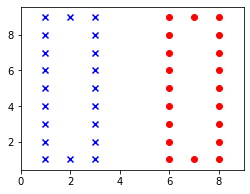

In [15]:
fig, ax = plt.subplots(1,1,figsize=(4,3))

# fancy way to get cross-product of points
left  = np.mgrid[1:4:2, 1:10].reshape(2, -1).T
right = np.mgrid[6:9:2, 1:10].reshape(2, -1).T

ax.scatter(left[:,0] , left[:,1] , c='b', marker='x')
ax.scatter([2,2], [1,9], c='b', marker='x')
ax.scatter(right[:,0], right[:,1], c='r', marker='o')
ax.scatter([7,7], [1,9], c='r', marker='o')
ax.set_xlim(0,9);

We have lost anything is the problem is set with the hull of the data. We can continue reducing the data we need to form that max-margin separating line. Really, we do NOT need the entire border of both classes. Only the boundary points facing the opposing class really matter. So, we can drop the non-facing points.

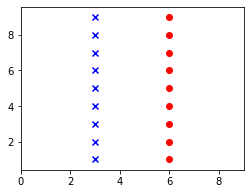

In [16]:
fig, ax = plt.subplots(1,1,figsize=(4,3))

left  = np.mgrid[3:4, 1:10].reshape(2, -1).T
right = np.mgrid[6:7, 1:10].reshape(2, -1).T

ax.scatter(left[:,0] , left[:,1] , c='b', marker='x')
ax.scatter(right[:,0], right[:,1], c='r', marker='o')
ax.set_xlim(0,9);

We worked out way down to a potentially much smaller set of data points. We focus on the points that matter, which is called support vectors, or supporting examples. 

In conclusion, a support vector classifier (SVC) is to 

  * find the support vectors - the border points
  * do the mathematics necessary to figure out the maximum margin separator
  
SVCs try to balance off two competing concerns: getting the biggest margin between the example classes and minimizing the number of training error. 

Short remarks:

  * SVC allows for storing more data, compared with $k$-NN
  * From SVC to SVM, the boundary is not necessarily linear

**Performance of SVC**

SVC are NOT naturally suited with multiclass clasification. They are typically wrapped up in either one-versus-one (OVO) or one-versus-rest (OVR) systems. In "sklearn" the SVC is a mix of OvO and OvR. 

There are four ways (actually more) that we can get a SVC in "sklearn"

  * LinearSVC
  * SVC with a linear kernel 
  * SVC with a polynomial kernel of degree 1
  * NuSVC with a linear kernel

In [17]:
#svm.NuSVC?

In [18]:
#svm.SVC?

The option "C" controls the maximal tolerance on the classification error;

The option "$\nu$" has a simple meaning: at least $\nu\%$ of the data will be kept as a support vector. It also has a consequence on error, but errors of a special type: margin errors. 
  
  * either on the wrong side of the separator 
  * or on the correct side of the separator  (correctly classified) but within the margin
  
  Under certain circumstance, margin errors increase to $\nu$ and support vectors decrease to $\nu$. 
  
  Let's look at how varying $C$ and $\nu$ affects the boundary between class.

In [19]:
from sklearn import svm
sv_classifiers = {"SVC(Linear)"   : svm.SVC(kernel='linear'),
                  "NuSVC(Linear)" : svm.NuSVC(kernel='linear', nu=.9)} 

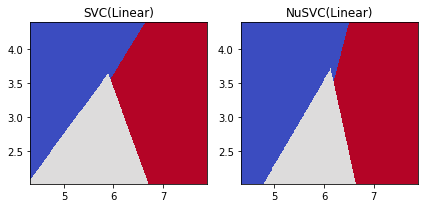

In [20]:
fig, axes = plt.subplots(1,2,figsize=(6,3))
for (name, mod), ax in zip(sv_classifiers.items(), axes.flat):
    plot_boundary(ax, iris.data, iris.target, mod, [0,1])
    ax.set_title(name)
plt.tight_layout()

In [21]:
def np_cartesian_product(*arrays):
    ndim = len(arrays)
    return np.stack(np.meshgrid(*arrays), axis=-1).reshape(-1, ndim)

In [22]:
def plot_separator(model, xs, ys, label='', ax=None):
    ''' xs, ys are 1-D b/c contour and decision_function
        use incompatible packaging '''
    if ax is None:
        ax = plt.gca()

    xy = np_cartesian_product(xs, ys)
    z_shape = (xs.size, ys.size) # verus shape[0]?
    zs = model.decision_function(xy).reshape(z_shape)

    contours = ax.contour(xs, ys, zs,
                          colors='k', levels=[0],
                          linestyles=['-'])
    fmt = {contours.levels[0] : label}
    labels = ax.clabel(contours, fmt=fmt, inline_spacing=10)
    [l.set_rotation(-90) for l in labels]

In [23]:
def do_linear_svc_separators(svc_maker, pname, params, ax):
    'create svc(params) and draw seperation boundary'
    xys = (np.linspace(2,8,100),
           np.linspace(2,8,100))

    for p in params:
        kwargs = {pname:p, 'kernel':'linear'}
        svc = svc_maker(**kwargs).fit(ftrs, tgt)
        # plot_separator is in mlwpy.py
        plot_separator(svc, *xys, 
                       '{}={:g}'.format(pname, p), ax=ax)

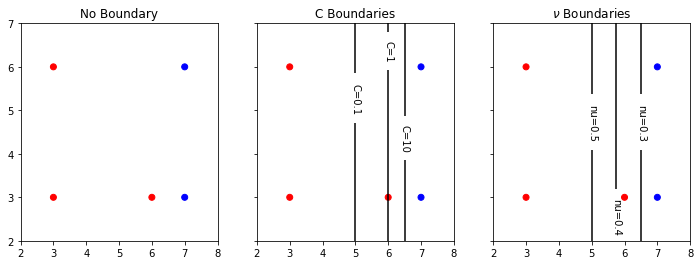

In [24]:
ftrs = np.array([[3,3],
                 [3,6],
                 [7,3],
                 [7,6],
                 [6,3]])
tgt  = np.array([0,0,1,1,0])
colors = np.array(['r', 'b'])

Cs = [.1, 1.0, 10]
nus = [.3, .4, .5]

fig, axes = plt.subplots(1,3,figsize=(12,4),
                         sharex=True, sharey=True)
for ax in axes:
    ax.scatter(ftrs[:,0], ftrs[:,1], c=colors[tgt])
ax.set_xlim(2,8); ax.set_ylim(2,7)

do_linear_svc_separators(svm.SVC,   "C",   Cs, axes[1])
do_linear_svc_separators(svm.NuSVC, "nu", nus, axes[2])

axes[0].set_title("No Boundary")
axes[1].set_title("C Boundaries")
axes[2].set_title(r"$\nu$ Boundaries");

**Bias and Variance in SVC**

  * Large $\nu$ gives awful performance on training and testing. (too biased)
  * Decreasing $\nu$ may give overfitting
  * High value of $C$ leads to overfitting and low value of $C$ leads to underfitting

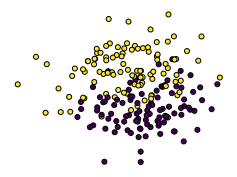

In [25]:
ftrs, tgt = datasets.make_blobs(centers=2,
                                n_features=3,
                                n_samples=200,
                                center_box = [-2.0, 2.0],
                                random_state=1099)

# note, using three features, but graphing only two dimensions
fig, ax = plt.subplots(1,1,figsize=(4,3))
ax.scatter(ftrs[:, 0], ftrs[:, 1], 
           marker='o', c=tgt, s=25, edgecolor='k')
ax.axis('off');

In [26]:
# adjusted to remove infeasible nu values
nus = np.linspace(0.05, .85, 9)
tt = skms.validation_curve(svm.NuSVC(kernel='linear'), 
                           ftrs, tgt, 
                           param_name='nu',
                           param_range=nus,
                           cv=5)

In [27]:
def sk_graph_to_tidy(train_test_scores, # y values
                     eval_points,       # x values
                     eval_label,        # x column name
                     num_folds):        # could be inferred
    train_scores, test_scores = train_test_scores
    # humph, didn't know np_cartesian was order sensitive
    labels = np_cartesian_product(eval_points,
                                  [0,1], # surrogates for train/test
                                  np.arange(num_folds))
    score = np.concatenate([train_scores.flatten(),
                            test_scores.flatten()], axis=0)

    df = pd.DataFrame.from_records(labels)
    df.columns = [eval_label, 'set', 'fold']
    df.set = df.set.replace({0:'Train', 1:'Test'})
    df['score'] = score
    return df


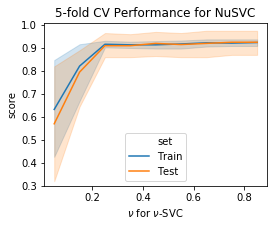

In [28]:
fig,ax = plt.subplots(1,1,figsize=(4,3))

tidy_df = sk_graph_to_tidy(tt, nus, 'nu', 5)
ax = sns.lineplot(x='nu', y='score', hue='set', data=tidy_df)

ax.set_title('5-fold CV Performance for NuSVC')
ax.set_xlabel("\n".join([r'$\nu$ for $\nu$-SVC']))
ax.set_ylim(.3, 1.01)
ax.legend(loc='lower center');

In [29]:
cs = [0.0001, 0.001, 0.01, .1, 1.0, 10, 100, 1000]
tt = skms.validation_curve(svm.SVC(kernel='linear'), 
                           ftrs, tgt, 
                           param_name='C',
                           param_range=cs,
                           cv=5)

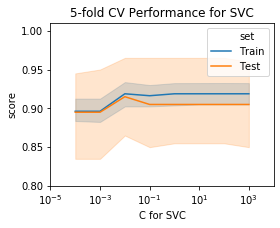

In [30]:
fig,ax = plt.subplots(1,1,figsize=(4,3))

tidy_df = sk_graph_to_tidy(tt, cs, 'c', 5)
ax = sns.lineplot(x='c',y='score',hue='set',data=tidy_df)

ax.set_title('5-fold CV Performance for SVC')
ax.set_xlabel("\n".join([r'C for SVC']))
ax.set_ylim(.8, 1.01)
ax.set_xlim(.00001, 10001)
ax.set_xscale('log')

**Logistic regression**

Logistic regression works in two stages:

  * it computes something closely related to the probabilities of being in each target class
  * it labels an example with the highest-probability class
  
Step one is a regression, which is tightly linked to linear regression. The value to be predicted is in the term of *log-odds*.

**odds, log-odds**

In a game, you have $10\%$ chance to win. We write those odds as $1:9$ (ratio between two classes?).

In [31]:
def simple_argmax(arr):
    ' helper to convert np.argmax into something usable '
    return np.array(np.unravel_index(np.argmax(arr), 
                                     arr.shape))

def df_names(df, idxs):
    ' helper to convert number of index/column labels '
    r,c = idxs
    return df.index[r], df.columns[c]

In [32]:
base_bets = np.arange(1,12,2)
mark_bet, andy_bet = np.meshgrid(base_bets, base_bets)

mark_winnings = .1 * andy_bet + .9 * -mark_bet

df = pd.DataFrame(mark_winnings, 
                  index  =base_bets, 
                  columns=base_bets)
df.index.name = "Andy Bet"
df.columns.name = "Mark Bet"

print("Best Betting Scenario (for Mark) for These Values:")
print("(Andy, Mark):", df_names(df, simple_argmax(mark_winnings)))

display(df)

Best Betting Scenario (for Mark) for These Values:
(Andy, Mark): (11, 1)


Mark Bet,1,3,5,7,9,11
Andy Bet,,,,,,
1,-0.8,-2.6,-4.4,-6.2,-8.0,-9.8
3,-0.6,-2.4,-4.2,-6.0,-7.8,-9.6
5,-0.4,-2.2,-4.0,-5.8,-7.6,-9.4
7,-0.2,-2.0,-3.8,-5.6,-7.4,-9.2
9,0.0,-1.8,-3.6,-5.4,-7.2,-9.0
11,0.2,-1.6,-3.4,-5.2,-7.0,-8.8


In [33]:
tail_probs = [0.0, .001, .01, .05, .10, .25, 1.0/3.0]

lwr_probs = np.array(tail_probs)
upr_probs = 1-lwr_probs[::-1]
cent_prob = np.array([.5])

probs = np.concatenate([lwr_probs, cent_prob, upr_probs])

# much better than geterr/seterr/seterr
with np.errstate(divide='ignore'):
    odds     = probs / (1-probs)
    log_odds = np.log(odds)

index=["{:4.1f}%".format(p) for p in np.round(probs,3)*100]

polo_dict = co.OrderedDict([("Prob(E)",       probs), 
                            ("Odds(E:not E)", odds), 
                            ("Log-Odds",      log_odds)])
polo_df = pd.DataFrame(polo_dict, index=index)
polo_df.index.name="Pct(%)"
polo_df

,Prob(E),Odds(E:not E),Log-Odds
Pct(%),,,
0.0%,0.000000,0.000000,-inf
0.1%,0.001000,0.001001,-6.906755
1.0%,0.010000,0.010101,-4.595120
5.0%,0.050000,0.052632,-2.944439
10.0%,0.100000,0.111111,-2.197225
25.0%,0.250000,0.333333,-1.098612
33.3%,0.333333,0.500000,-0.693147
50.0%,0.500000,1.000000,0.000000
66.7%,0.666667,2.000000,0.693147


Let's look at the relationship between probabilities and odds.

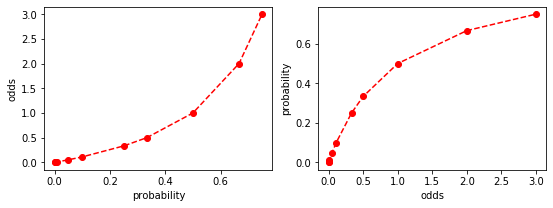

In [34]:
def helper(ax,x,y,x_name,y_name):
    ax.plot(x,y, 'r--o')
    ax.set_xlabel(x_name)
    ax.set_ylabel(y_name)

# note, we trim the values above 90% [index -5] b/c 
# the scale of the plots gets too compressed
# (huh, log-scale takes care of that! funny .....)
fig, (ax0, ax1) = plt.subplots(1,2, figsize=(9,3))
helper(ax0, probs[:-5], odds[:-5], 'probability', 'odds')
helper(ax1, odds[:-5], probs[:-5], 'odds', 'probability')

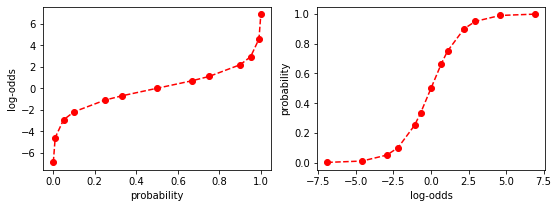

In [35]:
fig, (ax0, ax1) = plt.subplots(1,2, figsize=(9,3))
helper(ax0, probs, log_odds, 'probability', 'log-odds')
helper(ax1, log_odds, probs, 'log-odds', 'probability')

One can see the extreme values for each of the probabilities, odds and log-odds.

In [36]:
pd.DataFrame([polo_df.min(axis=0),
              polo_df.max(axis=0)], index=['min', 'max']).T

,min,max
Prob(E),0.0,1.0
Odds(E:not E),0.0,inf
Log-Odds,-inf,inf


In [37]:
def logit(probs):
    odds = probs / (1-probs)
    log_odds = np.log(odds)
    return log_odds

The basic model of logistic regression is as follows

$$
LO = \sum_{ftrs} w_f x_f.
$$

"sklearn" provides two classes "LogisticRegression" and " SGDclassifier". "SGDclassifier" makes its adjustments by looking at the errors in the current guess and using those to lower the error of the next guess - a kind of smart guess.

The option "saga" allows us to use a full multiclass model instead of wrapping a binary classification with one-versus-rest.

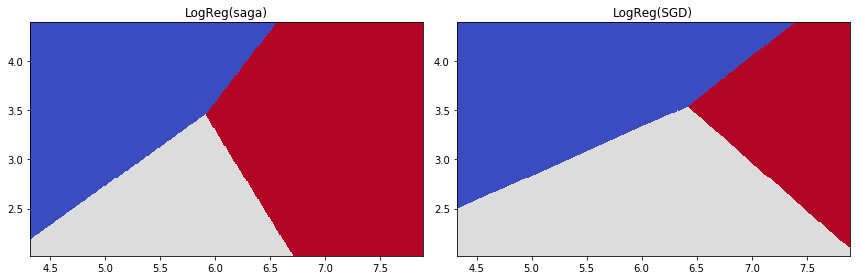

In [38]:
# Both options come with "regularization" turned ON, 
LogReg = linear_model.LogisticRegression
SGD    = linear_model.SGDClassifier
logreg_classifiers = {'LogReg(saga)': LogReg(solver='saga', 
                                             multi_class='multinomial',
                                             max_iter=1000),
                      'LogReg(SGD)' :  SGD(loss='log', max_iter=1000)}

fig, axes = plt.subplots(1,2,figsize=(12,4))
axes = axes.flat
for (name, mod), ax in zip(logreg_classifiers.items(), axes):
    plot_boundary(ax, iris.data, iris.target, mod, [0,1])
    ax.set_title(name)
plt.tight_layout()

**Logistic regression does NOT work well with perfectly separable data**

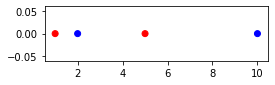

In [39]:
fig, ax = plt.subplots(1,1,figsize=(4,1))

x = np.array([1,2,5,10]).reshape(-1, 1)
y = ['red', 'blue', 'red', 'blue']
ax.scatter(x,np.zeros_like(x), c=y);

In [40]:
# note:  different import source
import statsmodels.api as sm

x = np.c_[x, np.ones_like(x)] # +1 trick
tgt = (np.array(y) == 'red')

# sm.Logit is statsmodels name for logistic regression
(sm.Logit(tgt, x, method='newton')
   .fit()
   .predict(x))  # training predictions

Optimization terminated successfully.
         Current function value: 0.595215
         Iterations 5


array([0.71833641, 0.6583037 , 0.45370855, 0.16965134])

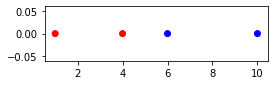

In [41]:
fig, ax = plt.subplots(1,1,figsize=(4,1))

x = np.array([1,4,6,10]).reshape(-1, 1)
y = ['red', 'red', 'blue', 'blue']
ax.scatter(x, np.zeros_like(x), c=y);

In [42]:
x = np.c_[x, np.ones_like(x)] # +1 trick
tgt = (np.array(y) == 'red')
try:
    (sm.Logit(tgt, x, method='newton')
       .fit()
       .predict(x)) # in-sample predictions
except Exception as e:
    print(e)

Perfect separation detected, results not available


**Discriminant analysis (DA)**

Discriminant analysis includes a large class of statistical methods. 

  * They have a clear mathematical connection with NB on continuous features
  * Different DA methods make different assumptions
  
For instance, we have two features:

  * Features one and two talk to each other. They care what Class has to say.
  * Features one and two talk to each other. They don't care what Class has to say.
  * Feature one doesn't talk to Feature two directly. Anything Feature one knows comes from talking to Class. 
  * Feature one doesn't talk directly to feature two nor does it care what Class has to say. 
  
  This is corresponding to the four methods that we shall learn in the sequel, QDA, LDA, GNB and DLDA.
  
  Mathematically, how feature one talks to feature two is modeled by covariance.

**Variance and covariance**

Variance:

$$
Var(X) = \frac{1}{n}\sum_{x\in X}(x-\overline{X})^2
$$

In [43]:
X = np.array([1,3,5,10,20])
n = len(X)

mean_X = sum(X) / n
errors = X - mean_X
var_X = np.dot(errors, errors) / n

fmt = "long way: {}\nbuilt in: {}\n   close: {}"
print(fmt.format(var_X, 
                 np.var(X), 
                 np.allclose(var_X, np.var(X)))) # phew

long way: 46.16
built in: 46.16
   close: True


Covariance:

$$Cov(X, Y) = \frac{1}{n} \sum_{x\in X\ y\in Y}(x-\overline{X})(y-\overline{Y})$$

In [44]:
X = np.array([1,3,5,10,20])
Y = np.array([2,4,1,-2,12])

mean_X = sum(X) / n
mean_Y = sum(Y) / n

errors_X = X - mean_X
errors_Y = Y - mean_Y

cov_XY = np.dot(errors_X, errors_Y) / n
print("long way: {:5.2f}".format(cov_XY))
print("built in:", np.cov(X,Y,bias=True)[0,1])
# note:
# np.cov(X,Y,bias=True) gives [Cov(X,X), Cov(X,Y)
#                              Cov(Y,X), Cov(Y,Y)]

long way: 21.28
built in: 21.28


**Alternative approach**

$$
Var(X) = \frac{1}{n^2} \sum_{i}\sum_{j>i}(x_i-x_j)^2
$$

$$
Cov(X, Y) = \frac{1}{n^2} \sum_{i}\sum_{j>i} (x_i-x_j)(y_i-y_j)
$$

or 

$$
Cov（X, Y) = \frac{1}{2n^2} \sum_{i,j} (x_i - x_j)(y_i - y_j)
$$

In [45]:
var_x = 0
n = len(X)
for i in range(n):
    for j in range(i, n): # rest of Xs
        var_x += (X[i] - X[j])**2
print("Var(X):", var_x / n**2)

Var(X): 46.16


In [46]:
cov_xy = 0
for i in range(len(X)):
    for j in range(i, len(X)): # rest of Xs, Ys
        cov_xy += (X[i] - X[j])*(Y[i]-Y[j])
print("Cov(X,Y):", cov_xy / n**2)

Cov(X,Y): 21.28


In [47]:
import itertools as it
cov_XY = 0.0
xy_pairs = it.product(zip(X,Y), repeat=2)
for (x_i, y_i), (x_j,y_j) in xy_pairs:
    cov_XY += (x_i - x_j) * (y_i - y_j)
print("Cov(X,Y):", cov_XY / (2 * n**2))

Cov(X,Y): 21.28


In [48]:
cov_XX = 0.0
for x_i, x_j in it.combinations(X, 2):
    cov_XX += (x_i - x_j)**2
print("Cov(X,X) == Var(X):", cov_XX / (n**2))

Cov(X,X) == Var(X): 46.16


In [49]:
cov_XY = 0.0
for (x_i, y_i), (x_j,y_j) in it.combinations(zip(X,Y), 2):
    cov_XY += (x_i - x_j) * (y_i - y_j)
print("Cov(X,Y):", cov_XY / (n**2))

Cov(X,Y): 21.28


**Visualizing covariance**

From the following equation

$$
Cov（X, Y) = \frac{1}{2n^2} \sum_{i,j} (x_i - x_j)(y_i - y_j)
$$

we find that the covariance is the sum of the areas of rectangles or a sum product of distances. In particular, these areas are signed areas.

Taking 3 2D-examples, in the following graph, we shall draw the diagonal of each of the three rectangles and we shall color in the total contributions at each region of grid. 

  * Red indicates a positive overall covariance; 
  * Blue indicates a negative covariance;
  * Darker colors indicate more covariance in either the positive or negative direction;
  * White indicates a lack of covariance.

In [50]:
# color coding
# -inf -> 0; 0 -> .5; inf -> 1
# slowly at the tails; quickly in the middle (near 0)
def sigmoid(x):  
    return np.exp(-np.logaddexp(0, -x))

# to get the colors we need, we have to build a raw array
# with the correct values.  we are really "drawing"
# inside a numpy array, not on the screen
def draw_rectangle(arr, pt1, pt2):
    (x1,y1),(x2,y2) = pt1,pt2
    delta_x, delta_y = x2-x1, y2-y1
    r,c = min(y1,y2), min(x1,x2)  # x,y -> r,c
    # assign +/- 1 to each block in the rectangle.  
    # total summation value equals area of rectangle (signed for up/down)
    arr[r:r+abs(delta_y), 
        c:c+abs(delta_x)] += np.sign(delta_x * delta_y)

In [51]:
# our data points:
pts = [(1,1), (3,6), (6,3)]
pt_array = np.array(pts, dtype=np.float64)

# the array we are "drawing" on:
draw_arr = np.zeros((10,10))
ct = len(pts)
c_magic = 1 / ct**2 # without double counting

# we use the clever, don't double count method
for pt1, pt2 in it.combinations(pts, 2):
    draw_rectangle(draw_arr, pt1, pt2)
draw_arr *= c_magic

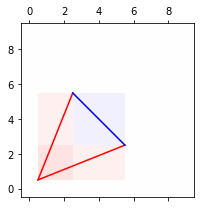

In [52]:
# display the array we drew
from matplotlib import cm
fig, ax = plt.subplots(1,1,figsize=(4,3))
ax.matshow(sigmoid(draw_arr), origin='lower', cmap=cm.bwr, vmin=0, vmax=1)
fig.tight_layout()

# show a diagonal across each rectangles
# the array elements are centered in each grid square
ax.plot([ .5, 2.5],[ .5, 5.5], 'r')  # from 1,1 to 3,6 
ax.plot([ .5, 5.5],[ .5, 2.5], 'r')  # from 1,1 to 6,3
ax.plot([2.5, 5.5],[5.5, 2.5], 'b');  # from 3,6 to 6,3

The total covariance for the pair of points is divided equally among the squares of the rectangle. To get the final color, we add up all the contributions, we've gotten along the way. Finally, we divide by the number of points squared.

In [53]:
np_cov = np.cov(pt_array[:,0], pt_array[:,1], bias=True)[0,1]
print("Cov(x,y) -   from numpy: {:4.2f}".format(np_cov))

# show the covariance, as calculated from our drawing
print("Cov(x,y) - our long way: {:4.2f}".format(draw_arr.sum()))

Cov(x,y) -   from numpy: 1.22
Cov(x,y) - our long way: 1.22


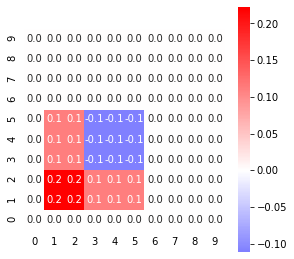

In [54]:
plt.figure(figsize=(4.5,4.5))
hm = sns.heatmap(draw_arr, center=0, 
                 square=True, annot=True, 
                 cmap='bwr', fmt=".1f")
hm.invert_yaxis()
hm.tick_params(bottom=False, left=False)

If we have more than two features, the correlation between features are described by the so-called covariance matrix. This is a symmetric matrix.

In [55]:
data = pd.DataFrame({'X':[ 1, 3, 6], 
                     'Y':[ 1, 6, 3], 
                     'Z':[10, 5, 1]})
data.index.name = 'examples'

# it's not critical to these examples, but Panda's cov is 
# "unbiased" and we've been working with "biased" cov.
# see EOC notes for details
display(data)
print("Covariance:")
display(data.cov())

,X,Y,Z
examples,,,
0,1,1,10
1,3,6,5
2,6,3,1


Covariance:


,X,Y,Z
X,6.333333,1.833333,-11.166667
Y,1.833333,6.333333,-5.166667
Z,-11.166667,-5.166667,20.333333


In [56]:
data = pd.DataFrame({'x':[ 3, 6, 3, 4], 
                     'y':[ 9, 6, 3, 0],
                     'z':[ 1, 4, 7, 0]})
data.index.name = 'examples'
display(data)
print("Covariance:")
display(data.cov()) # biased covariance, see EOC

,x,y,z
examples,,,
0,3,9,1
1,6,6,4
2,3,3,7
3,4,0,0


Covariance:


,x,y,z
x,2.0,0.0,0.0
y,0.0,15.0,0.0
z,0.0,0.0,10.0


The following graph can illustrate wether we get a consistent "pattern", that is, "if $X$ goes up, $Y$ always goes up".

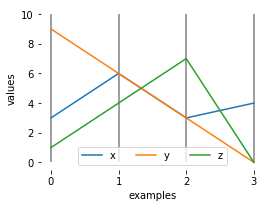

In [57]:
fig, ax = plt.subplots(1,1,figsize=(4,3))
data.plot(ax=ax)
ax.vlines([0,1,2,3], 0, 10, colors=".5")

ax.legend(loc='lower center', ncol=3)

plt.box(False)
ax.set_xticks([0,1,2,3])
ax.set_ylabel("values");

**QDA, LDA, GNB and DLDA**

These techniques make different assumptions about the covariances.

  * QDA (quadratic) assumes that covariance between different features are unconstrained
  * LDA (linear) assumes in addition that covariance between features are the same regardless of the target class. 
  * GNB (Gaussian) assumes in addition that the covariance between features are all 0
  * DLDA (Diagonal Linear) assumes in addition that the covariances among all the classes are the same
  
  That is 
  
  * QDA: possibly different covariance matrix per class $\Sigma_c$
  * LDA: same covariance matrix for all classes $\Sigma_c \equiv \Sigma$
  * GNB: different diagonal covariance matrices per class $\Sigma_c = diag_c$
  * DLDA: same diagonal covariance matrix for all classes $\Sigma_c\equiv diag$

**Performance of DA**

In [58]:
from sklearn.base import BaseEstimator, ClassifierMixin
class DLDA(BaseEstimator, ClassifierMixin):
    def __init__(self):
        pass

    def fit(self, train_ftrs, train_tgts):
        self.uniq_tgts = np.unique(train_tgts)
        self.means, self.priors = {}, {}

        self.var  = train_ftrs.var(axis=0) # biased
        for tgt in self.uniq_tgts:
            cases = train_ftrs[train_tgts==tgt]
            self.means[tgt]  = cases.mean(axis=0)
            self.priors[tgt] = len(cases) / len(train_ftrs)
        return self

    def predict(self, test_ftrs):
        disc = np.empty((test_ftrs.shape[0],
                         self.uniq_tgts.shape[0]))
        for tgt in self.uniq_tgts:
            # technically, the maha_dist is sqrt() of this:
            mahalanobis_dists = ((test_ftrs - self.means[tgt])**2 /
                                 self.var)
            disc[:,tgt] = (-np.sum(mahalanobis_dists, axis=1) +
                           2 * np.log(self.priors[tgt]))
        return np.argmax(disc,axis=1)

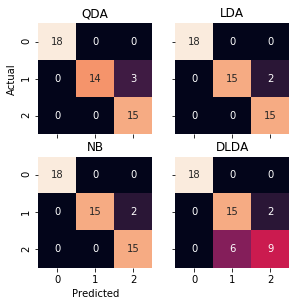

In [59]:
from sklearn import discriminant_analysis
qda  = discriminant_analysis.QuadraticDiscriminantAnalysis()
lda  = discriminant_analysis.LinearDiscriminantAnalysis()
nb   = naive_bayes.GaussianNB()
dlda = DLDA()

da_methods = [qda, lda, nb, dlda]
names = ["QDA", "LDA", "NB", "DLDA"]
    
fig, axes = plt.subplots(2,2, figsize=(4.5, 4.5),
                         sharex=True, sharey = True)
for ax, model, name in zip(axes.flat, da_methods, names):
    preds = (model.fit(iris_train_ftrs, iris_train_tgt)
                  .predict(iris_test_ftrs))
    cm = metrics.confusion_matrix(iris_test_tgt, preds)
    sns.heatmap(cm, annot=True, cbar=False, ax=ax)
    ax.set_title(name)

axes[0,0].set_ylabel('Actual')
axes[1,0].set_xlabel('Predicted');

LDA seems to be the best. Occam's razor: fewest assumption that get the job done. 

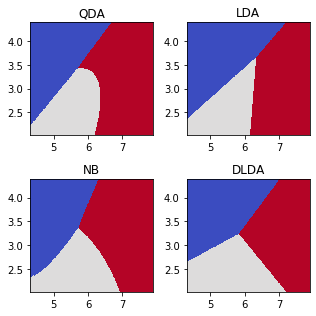

In [60]:
fig, axes = plt.subplots(2,2,figsize=(4.5, 4.5))
axes = axes.flat

for model, ax, name in zip(da_methods, axes, names):
    # plot boundary only uses the specified (two) dimensions to predict
    plot_boundary(ax, iris.data, iris.target, model, [0,1])
    ax.set_title(name)
plt.tight_layout()

**Discussion on assumptions**

A problem : if $y>x$.

In [61]:
def get_model_name(model):
    ' return name of model (class) as a string '
    return str(model.__class__).split('.')[-1][:-2]

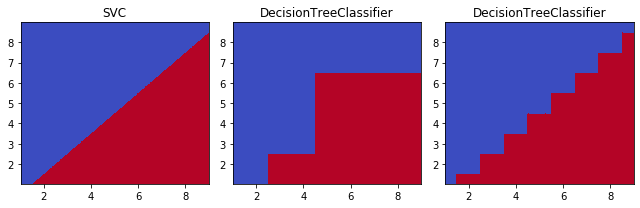

In [62]:
ftrs = np.mgrid[1:10, 1:10].T.reshape(-1,2)
tgt  = ftrs[:,0] > ftrs[:,1]

fig, axes = plt.subplots(1,3,figsize=(9,3))
axes = axes.flat

svc = svm.SVC(kernel='linear')
dt_shallow  = tree.DecisionTreeClassifier(max_depth=3)
dt_deep     = tree.DecisionTreeClassifier()
models = [svc, dt_shallow, dt_deep]

for model, ax in zip(models, axes):
    # plot boundary only uses the specified (two) dimensions to predict
    plot_boundary(ax, ftrs, tgt, model, [0,1])
    ax.set_title(get_model_name(model))
plt.tight_layout()

**Comparison of classifiers**

In [63]:
digits = datasets.load_digits()

Shape: (8, 8)


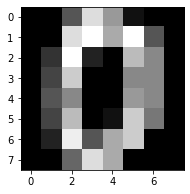

In [64]:
print("Shape:", digits.images[0].shape)
plt.figure(figsize=(3,3))
plt.imshow(digits.images[0], cmap='gray');

In [65]:
digits.target[0]

0

In [66]:
from sklearn import model_selection as skms
classifier_parade = \
    {'LogReg(1)' : linear_model.LogisticRegression(max_iter=1000),
     'LogReg(2)' : linear_model.SGDClassifier(loss='log',
                                              max_iter=1000),

     'QDA' : discriminant_analysis.QuadraticDiscriminantAnalysis(),
     'LDA' : discriminant_analysis.LinearDiscriminantAnalysis(),
     'GNB' : naive_bayes.GaussianNB(),

     'SVC(1)' : svm.SVC(kernel="linear"),
     'SVC(2)' : svm.LinearSVC(),

     'DTC' : tree.DecisionTreeClassifier(),
     '5NN-C' : neighbors.KNeighborsClassifier(),
     '10NN-C' : neighbors.KNeighborsClassifier(n_neighbors=10)}



baseline = dummy.DummyClassifier(strategy="uniform")

base_score = skms.cross_val_score(baseline, digits.data, digits.target==1, 
                                  cv=10, scoring = 'average_precision')

In [67]:
for name, model in classifier_parade.items():    
    cv_scores = skms.cross_val_score(model, 
                                     digits.data, digits.target, 
                                     cv=10, 
                                     scoring='f1_macro')

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-reg

/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-reg

/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


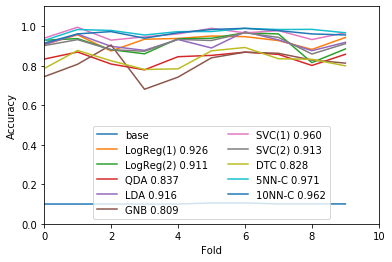

In [73]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(6,4))
ax.plot(base_score, label='base')
for name, model in classifier_parade.items():    
    cv_scores = skms.cross_val_score(model, 
                                     digits.data, digits.target, 
                                     cv=10, 
                                     scoring='f1_macro')
    my_lbl = "{} {:.3f}".format(name, cv_scores.mean())
    ax.plot(cv_scores, label=my_lbl)
ax.set_xlim(0,10)
ax.set_ylim(0.0, 1.1)
#plt.xticks(np.linspace(0, 10, 5))
ax.set_xlabel('Fold')
ax.set_ylabel('Accuracy')
ax.legend(loc='lower center', ncol=2);

Ex1. Prove that the alternative way to computer the variance and the covariance of examples is equivalent to the classical way.

Ex2. Prove that the DLDA model have linear borders between classes (consider the simplest case: 2D input features, 2 classes, the conditional distribution of the input features given classes is gaussian).